In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

# Читаем данные
raw_data = pd.read_csv('grand_train.csv', low_memory=False)
# Изменим дэфолтное значение pandas на вывод строк
pd.options.display.max_rows = 8000
# Выведим информацию о количестве  NA значений в столбцах
print(raw_data.isna().sum())

Grant.Application.ID                          0
Grant.Status                                  0
Sponsor.Code                                912
Grant.Category.Code                         912
Contract.Value.Band...see.note.A           3563
Start.date                                    0
RFCD.Code.1                                 634
RFCD.Percentage.1                           634
RFCD.Code.2                                 634
RFCD.Percentage.2                           634
RFCD.Code.3                                 634
RFCD.Percentage.3                           634
RFCD.Code.4                                 634
RFCD.Percentage.4                           634
RFCD.Code.5                                 634
RFCD.Percentage.5                           634
SEO.Code.1                                  664
SEO.Percentage.1                            664
SEO.Code.2                                  664
SEO.Percentage.2                            664
SEO.Code.3                              

In [2]:
# Всего строк 8708, можно заметить, что очень много столбцов, в которых вообще нет значений
# Поэтому сбалансируем выборку
# Из описание датасета стало понятно, что у нас есть информация о грантополучателе
# А также информация о его команде, в которой может быть до 15 человек
# Большинство Грантополучателей работали одни
# Поэтому попробуем построить модель на основе информации
# Только грантополучателя (Первые 40 столбцов)
data1 = raw_data.iloc[:, 1:40]

print(type(data1))

print(data1.isna().sum())

# Также уберём столбцы, которые на наш взгляд не влияют на получение гранта
# Такие как, дата рождения, город, спонсор, дата начала и т.д.
data2=data1.drop(['Country.of.Birth.1','Sponsor.Code','Grant.Category.Code','Start.date','Contract.Value.Band...see.note.A','Home.Language.1','With.PHD.1','No..of.Years.in.Uni.at.Time.of.Grant.1'],axis =1)

# Уберём NA значения
data3 = data2.dropna()

# Выведем информацию о типах столбцов
print(data3.dtypes)

# Один из столбцов object, передалаем в категориальную
data3['Role.1'] = data3['Role.1'].astype('category').cat.codes

# X - это данные на которых будет обучаться модели
X = data3.drop(['Grant.Status'],axis =1)
# Y - это проверка, правильно ли обучилась модель
Y = data3['Grant.Status']

# Выделяем под тренировку и тесты данные, 0.2 (20%) на тестирование модели
# Остальное на обучение 
X_train, X_test, Y_train , Y_test = train_test_split(X, Y, test_size =0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Grant.Status                                 0
Sponsor.Code                               912
Grant.Category.Code                        912
Contract.Value.Band...see.note.A          3563
Start.date                                   0
RFCD.Code.1                                634
RFCD.Percentage.1                          634
RFCD.Code.2                                634
RFCD.Percentage.2                          634
RFCD.Code.3                                634
RFCD.Percentage.3                          634
RFCD.Code.4                                634
RFCD.Percentage.4                          634
RFCD.Code.5                                634
RFCD.Percentage.5                          634
SEO.Code.1                                 664
SEO.Percentage.1                           664
SEO.Code.2                                 664
SEO.Percentage.2                           664
SEO.Code.3                                 664
SEO.Percentage.3      

C:\Users\Timur\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.54      0.86      0.66       764
           1       0.54      0.18      0.27       685

    accuracy                           0.54      1449
   macro avg       0.54      0.52      0.47      1449
weighted avg       0.54      0.54      0.48      1449



In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [6]:
from sklearn.model_selection import GridSearchCV

# Для того чтобы обучить модель, нужно подобрать лучшую по параметрам
# Возьмём RandomForest, суть алгоритма заключается в том, что
# Мы берём не одно дерево решений, а множество
# И при выборе решения предпочтение отдаётся
# Классу, за которой больше всего проголосовали деревья
# Критерий Entropy основывается на количестве информации
# В каждой вершине дерева, то есть берётся сравнение
# Энтропий (-{Sum}p(x)*log(p(x)), до появление
# нового предиката и после
clf = RandomForestClassifier(criterion='entropy')
# Для RandomForest сущетсвуют параметры max_depth (Максимальная глубина дерева)
# И n_estimators (Количество деревьев)
# Также существуют ещё параметры, но пока остановимся на этих
parametrs = {'max_depth':range(1,100, 10), 'n_estimators':range(1,100, 10)}
# Для нахождения лучших параметров будем использовать GridSearchCV
# Он переберёт все значения, которые мы задали, и найдёт наилучшее дерево
# У него есть также три параметра, которые здесь используются
# scoring - оценка лучше дерева по критерию
# В данном случае используется roc_auc (roc кривая) - это сравнение true positive 
# и false positive
# n_jobs - какое количество процессов будет задействевано, здесь используется -1
# Использовать все процессы
# cv - кросс валидация, при обучение часть выборки не используется в обучение
# Далее выбрасывается другая часть и обучается на оставшиейся
# И так 5 (В данном случае) раз
search = GridSearchCV(clf, parametrs, cv = 5, scoring = 'roc_auc', n_jobs = -1)
# Обучаем модель на наших данных
search.fit(X_train, Y_train)
# Находим наилучшее решение
best_tree_random_ent=search.best_estimator_
best_tree_random_ent
# Получилось 81 деревьев и глубина 11

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=81,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
# predict_proba предсказывает результат
y_pred_proba = best_tree_random_ent.predict_proba(X_test)[::,1]
# Подсчитываем значения для roc кривой на основе предсказанных
# значений и действительных
fprlr_random_search, tprlr_random_search, _ = metrics.roc_curve(Y_test,  y_pred_proba)
# Подсчитываем площадь под roc кривой
auclr_random_search = metrics.roc_auc_score(Y_test, y_pred_proba)
predictions = best_tree_random_ent.predict(X_test)
# Получим результаты модели
print(classification_report(Y_test, predictions))
# precision - это количество TruePositive на количество результатов, которые должны
# Были быть Positive (TP+FP)
# recall - это количество TruePositive на колиество Positive (TP+FN) результатов

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       764
           1       0.79      0.66      0.72       685

    accuracy                           0.76      1449
   macro avg       0.76      0.75      0.75      1449
weighted avg       0.76      0.76      0.75      1449



In [52]:
from sklearn.neighbors import KNeighborsClassifier
# Проделаем те же операции для модели
# К ближайших соседей, суть метода заключается в том
# Чтобы новому значению присвоить тот же класс, что 
# Что и у большинства его k соседей
clf = KNeighborsClassifier()
# n_neighbors - количество соседей
# p - мощность, расстояние счиатется по формуле
# ({Sum}|Xi - Yi|^p)^(1/p)
parametrs = {'n_neighbors':range(1, 100), 'p': range(1, 3)}
search = GridSearchCV(clf, parametrs, cv = 5, scoring = 'roc_auc', n_jobs=-1)
search.fit(X_train, Y_train)
best_tree_k=search.best_estimator_
y_pred = best_tree_k.predict_proba(X_test)[::, 1]
fprlr_k, tprlr_k, _ = metrics.roc_curve(Y_test, y_pred)
auclr_k = metrics.roc_auc_score(Y_test, y_pred)
predictions = best_tree_k.predict(X_test)
print(classification_report(Y_test, predictions))
# Precision и recall получился хуже, чем для random forest
# Это значит, что модели правильно определить
# Класс удалось хуже

              precision    recall  f1-score   support

           0       0.57      0.83      0.68       764
           1       0.62      0.31      0.42       685

    accuracy                           0.59      1449
   macro avg       0.60      0.57      0.55      1449
weighted avg       0.60      0.59      0.55      1449



In [54]:
from sklearn.tree import DecisionTreeClassifier
# Рассмотрим для примера обычное дерево решиний
# Чтобы убедиться, что обучения random forest помогло
# Ограничим глубиной до 10, иначе дерево будет иметь
# в листах по одному классу
# Это приведёт к тому, что на проверочной
# Выборке будут плохие результаты
clf = DecisionTreeClassifier(max_depth=10)
tree_simple = clf.fit(X_train, Y_train)
y_pred_proba = tree_simple.predict_proba(X_test)[::,1]
fprlr_s, tprlr_s, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auclr_s = metrics.roc_auc_score(Y_test, y_pred_proba)
predictions = tree_simple.predict(X_test)
print(classification_report(Y_test, predictions))
# Результаты получились даже лучше, чем у K соседей
# Но Random Forest получился лучше

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       764
           1       0.73      0.67      0.70       685

    accuracy                           0.73      1449
   macro avg       0.73      0.72      0.72      1449
weighted avg       0.73      0.73      0.73      1449



In [55]:
from sklearn.model_selection import train_test_split
from numpy import arange
# Рассмотрим ещё одну модель
# Логистическая регрессия
# Каждому признаку выставляется свой вес (Коэффициент)
# Если признак явно определяет к какому классу
# Попадает объект, то вес больше
# При обучение настраиваются веса
clf = LogisticRegression()
# Параметры penalty - определяют регуляцию модели
# Чтобы модель не переобучалась
# l2 сильно, а l1 нет режит коэффициенты
# С - контролирует силу регуляции
parametrs = {'C':arange(0.1, 1.1, 0.1), 'penalty':['l1', 'l2']}
search = GridSearchCV(clf, parametrs, cv = 5, scoring = 'roc_auc', n_jobs=-1)
search.fit(X_train, Y_train)
best_tree_logistic = search.best_estimator_
y_pred = best_tree_logistic.predict_proba(X_test)[::, 1]
fprlr_logistic, tprlr_logistic, _ = metrics.roc_curve(Y_test, y_pred)
auclr_logistic = metrics.roc_auc_score(Y_test, y_pred)
predictions = best_tree_logistic.predict(X_test)
print(classification_report(Y_test, predictions))
# Результаты получились такие же, как и при
# Обычном дереве решений

C:\Users\Timur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.72      0.79      0.76       764
           1       0.74      0.66      0.70       685

    accuracy                           0.73      1449
   macro avg       0.73      0.73      0.73      1449
weighted avg       0.73      0.73      0.73      1449



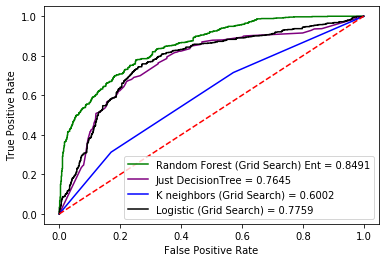

In [60]:
# Построим графики (Roc кривую) для всех моделей
plt.plot(fprlr_random_search, tprlr_random_search, 'b', color='g', label = 'Random Forest (Grid Search) Ent = %0.4f' % auclr_random_search)
plt.plot(fprlr_s, tprlr_s, 'b', color='purple', label = 'Just DecisionTree = %0.4f' % auclr_s)
plt.plot(fprlr_k, tprlr_k, 'b', color='b', label = 'K neighbors (Grid Search) = %0.4f' % (auclr_k))
plt.plot(fprlr_logistic, tprlr_logistic, 'b', color='black', label = 'Logistic (Grid Search) = %0.4f' % (auclr_logistic))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.grid(False)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc.png')
plt.show()
# В нашем задание получилось, что лучше подходит модель Random Forest

In [46]:
# Параметры, которые получились через SearchGridCV
best_tree_logistic

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
best_tree_random_ent

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=81,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
best_tree_k

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=1,
                     weights='uniform')

NameError: name 'X' is not defined